# Unsupervised Learning and K-Means Clustering

**Unsupervised Learning.** In some pattern recognition problems, the training data consists of a set of input vectors x without any corresponding target values. The goal in such unsupervised learning problems may be to discover groups of similar examples within the data, where it is called clustering, or to determine how the data is distributed in the space, known as density estimation. To put forward in simpler terms, for a n-sampled space x1 to xn, true class labels are not provided for each sample, hence known as learning without teacher.


**Issues with Unsupervised Learning:**
* Unsupervised Learning is harder as compared to Supervised Learning tasks..
* How do we know if results are meaningful since no answer labels are available?
* Let the expert look at the results (external evaluation)
* Define an objective function on clustering (internal evaluation)

**What is Clustering?**

Clustering can be considered the most important unsupervised learning problem; so, as every other problem of this kind, it deals with finding a structure in a collection of unlabeled data. A loose definition of clustering could be “the process of organizing objects into groups whose members are similar in some way”. A cluster is therefore a collection of objects which are “similar” between them and are “dissimilar” to the objects belonging to other clusters.

For this notebook we will need the following packages:
 * Statistics [documentation](https://docs.julialang.org/en/v1/stdlib/Statistics/)
 * Plots [documentation](http://docs.juliaplots.org/latest/)
 
---

In [1]:
using Statistics
using Plots
theme(:dark)

---

In the code cell below we generate artificial data that mimics clustered and unlabeled data. For this test of artificial data we assume all points in a given cluster lie within some circle of a given radius and center. 

---

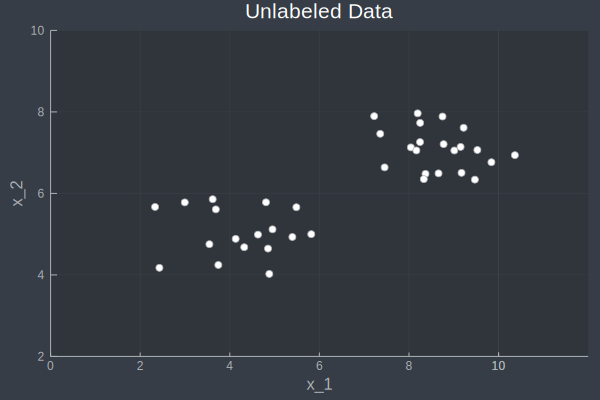

In [2]:
# How to form a circle! 
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    return h.+r*sin.(θ), k.+r*cos.(θ)
end


# Assume the center cluster1 is (4, 5) with radius 1.8
cluster1 = [(4 + (-1)^rand(1:2)*rand(1:2)*rand(), 5 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:17]

# Assume the center of cluster2 is (9, 7) with radius 2.2
cluster2 = [(9 + (-1)^rand(1:2)*rand(1:2)*rand(), 7 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:21]

data = copy(cluster1)
for x in cluster2
    push!(data, x)
end

plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Unlabeled Data")

scatter!(data, color = "white")

---

The goal of the $k$-means algorithm is to find groups in the data that are clustered by distance, with the number of groups represented by the variable $k$. The algorithm works iteratively to assign each data point to one of $k$ groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the $k$-means clustering algorithm are:

1. The centroids of the $k$ clusters are used to label new data (This is related to KNN)
2. Labels for the training data (each data point is assigned to a single cluster)

Rather than defining groups before looking at the data, clustering allows you to find and analyze the groups that have formed organically. Each centroid of a cluster is a collection of feature values which define the resulting groups. Examining the centroid feature weights can be used to qualitatively interpret what kind of group each cluster represents. 

Because we know the limits on the above experimental data, as well as the appropriate value for $k$ ($k = 1$),  we can show a plot with two circles enclosing the points we have produced. The following code cell illustrates how to show this plot. By using the $k$-means algorithm we wish to automatically generate these circles, or even better circles!

---

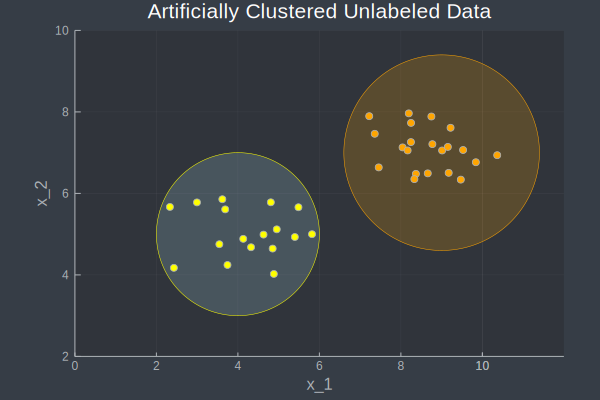

In [3]:
plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Artificially Clustered Unlabeled Data")


plot!(circleShape(4, 5, 2.0), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "yellow", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(9, 7, 2.4), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "orange", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

scatter!(cluster1, 
        color = "yellow", 
        legend = false)
scatter!(cluster2, 
        legend = false, 
        color = "orange")

In [4]:
# Define the Euclidean distance formula as a function
function euclidean_distance(p1, p2)
    return sqrt(sum([(p1[i] - p2[i])^2 for i = 1:length(p1)]))
end

euclidean_distance (generic function with 1 method)

In [5]:
function k_means_distances(X, centers, k)
    distances = Dict()
    for p in X
        temp_dict = Dict()
        for i = 1:k
            temp_dict[i] = euclidean_distance(p, centers[i])
        end
        distances[p] = temp_dict
    end
    return distances
end

function k_means_clusters(X, centers, k)
    distances = k_means_distances(X, centers, k)
    clusters = Dict()
    for p in X
        clusters[p] = 1
        min_d = distances[p][1]
        for i = 2:k
            if distances[p][i] < min_d
                clusters[p] = i
            end
        end
    end
    return clusters
end
    
function k_means_new_centers(X, centers, k)  
    clusters = k_means_clusters(X, centers, k)
    new_centers = []
    for j = 1:k
        x = mean([p[1] for p in keys(clusters) if clusters[p] == j])
        y = mean([p[2] for p in keys(clusters) if clusters[p] == j])
        point = (x, y)
        push!(new_centers, point)
    end
    return new_centers
    
end


k_means_new_centers (generic function with 1 method)

In [6]:
centers = k_means_new_centers(data, [(rand(1:10), rand(1:10)), (rand(1:10), rand(1:10))], 2);
for x in centers
    println(x)
end

(8.385853906326828, 6.940438250391396)
(4.021948575926305, 5.009032835432827)


---
**Stopping Criteria for K-Means Clustering**

There are essentially three stopping criteria that can be adopted to stop the K-means algorithm:
1. Centroids of newly formed clusters do not change
2. Points remain in the same cluster
3. Maximum number of iterations are reached

We can stop the algorithm if the centroids of newly formed clusters are not changing. Even after multiple iterations, if we are getting the same centroids for all the clusters, we can say that the algorithm is not learning any new pattern and it is a sign to stop the training.

Another clear sign that we should stop the training process if the points remain in the same cluster even after training the algorithm for multiple iterations.

Finally, we can stop the training if the maximum number of iterations is reached. Suppose if we have set the number of iterations as 100. The process will repeat for 100 iterations before stopping.

For our code we choose to stop when the centers do not change distance within some positive number $\epsilon$. 

---

In [7]:
function k_means_clustering(X, k, ϵ)
    
    # The following code ensures that each initial center is assigned a unique cluster
    centers = []
    x_lims = []
    y_lims = []
    sort!(X, by = x->x[1])
    push!(x_lims, X[1][1])
    push!(x_lims, X[end][1])
    sort!(X, by = x->x[2])
    push!(y_lims, X[1][2])
    push!(y_lims, X[end][2])
    m_x = (x_lims[2]-x_lims[1])/k
    m_y = (y_lims[2] -y_lims[1])/k
    centers = [(x_lims[1], y_lims[1])]
 
    # Now for the k-Means algorithm 
    for i = 1:k
        push!(centers, (centers[i][1] + m_x, centers[i][2] + m_y))
    end
    #centers = [(rand(1:15), rand(1:15)) for i = 1:k]
    new_centers = k_means_new_centers(X, centers, k)
    while maximum([euclidean_distance(centers[i], new_centers[i]) for i = 1:k]) > ϵ
        centers, new_centers = new_centers, k_means_new_centers(X, new_centers, k)
    end
    return new_centers
end

k_means_clustering (generic function with 1 method)

---

**Choosing K**

The algorithm described above finds the clusters and data set labels for a particular pre-chosen K. To find the number of clusters in the data, the user needs to run the K-means clustering algorithm for a range of K values and compare the results. In general, there is no method for determining exact value of K, but an accurate estimate can be obtained using the following techniques.

One of the metrics that is commonly used to compare results across different values of K is the mean distance between data points and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing K will always decrease this metric, to the extreme of reaching zero when K is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of K is plotted and the "elbow point," where the rate of decrease sharply shifts, can be used to roughly determine K.

A number of other techniques exist for validating K, including cross-validation, information criteria, the information theoretic jump method, the silhouette method, and the G-means algorithm. In addition, monitoring the distribution of data points across groups provides insight into how the algorithm is splitting the data for each K.

---

In [9]:
k_means_clustering(data, 2, 0.1)

2-element Array{Any,1}:
 (4.213776746811574, 5.046773891956801)
 (8.646174466124515, 7.093829339391854)

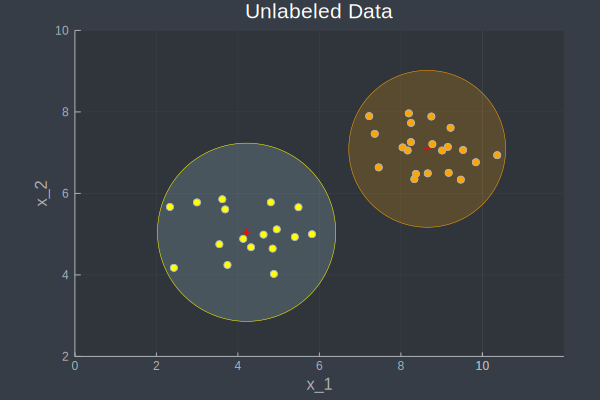

In [12]:
centers = k_means_clustering(data, 2, 0.1)
p1 = centers[1]
p2 = centers[2]

clusters = k_means_clusters(data, centers, 2)

rad1 = maximum([euclidean_distance(p, p1) for p in keys(clusters) if clusters[p] == 1]) + .2
rad2 = maximum([euclidean_distance(p, p2) for p in keys(clusters) if clusters[p] == 2]) + .2

plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Unlabeled Data")

scatter!(cluster1, 
        color = "white", 
        legend = false)

scatter!(cluster2, 
        legend = false, 
        color = "white")

plot!(circleShape(p1[1], p1[2], rad1), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "yellow", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p2[1], p2[2], rad2), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "orange", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

scatter!([x for x in keys(clusters) if clusters[x] == 1], 
        color = "yellow", 
        legend = false)
scatter!([x for x in keys(clusters) if clusters[x] == 2], 
        legend = false, 
        color = "orange")
scatter!([x for x in centers], shape = :+, color = "red")

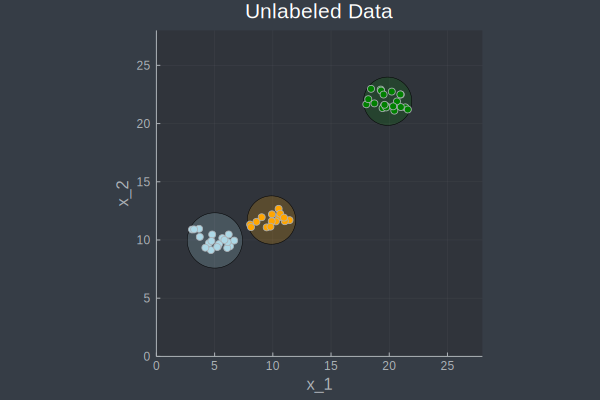

In [29]:
# Assume the center cluster1 is (4, 5)
cluster1 = [( 5+ (-1)^rand(1:2)*rand(1:2)*rand(), 10 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:19]

# Assume the center of cluster2 is (9, 7)
cluster2 = [(10 + (-1)^rand(1:2)*rand(1:2)*rand(), 12 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:15]

# Assume the center of cluster2 is (9, 7)
cluster3 = [(20 + (-1)^rand(1:2)*rand(1:2)*rand(), 22 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:21]

X = copy(cluster1)
for x in cluster2
    push!(X, x)
end
for x in cluster3
    push!(X, x)
end

centers = k_means_clustering(X, 3, 0.00001)
p1 = centers[1]
p2 = centers[2]
p3 = centers[3]

clusters = k_means_clusters(X, centers, 3)

rad1 = maximum([euclidean_distance(p, p1) for p in keys(clusters) if clusters[p] == 1]) + .2
rad2 = maximum([euclidean_distance(p, p2) for p in keys(clusters) if clusters[p] == 2]) + .2
rad3 = maximum([euclidean_distance(p, p3) for p in keys(clusters) if clusters[p] == 3]) + .2
plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 28),
    ylabel = "x_2",
    ylim = (0, 28), 
    title = "Unlabeled Data")


plot!(circleShape(p1[1], p1[2], rad1), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p2[1], p2[2], rad2), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p3[1], p3[2], rad3), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    color = "green", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)
scatter!([x for x in keys(clusters) if clusters[x] == 1], 
        color = "lightblue", 
        legend = false)
scatter!([x for x in keys(clusters) if clusters[x] == 2], 
        legend = false, 
        color = "orange")
scatter!([x for x in keys(clusters) if clusters[x] == 3], 
        legend = false, 
        color = "green")